In [27]:
import glob
import os
from PIL import Image, ImageOps
import numpy as np
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

from keras.layers import Dropout, Input, Dense, Activation,GlobalMaxPooling2D, BatchNormalization, Flatten, Conv2D, MaxPooling2D
from keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
import keras
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.callbacks import LearningRateScheduler, EarlyStopping
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

In [44]:
dir = './DataSet/Images/Autistic/train/'
ori_label = []
ori_imgs = []

for images in glob.iglob(f'{dir}/*'):
        ori_label.append(1)
        new_img = Image.open(images)
        ori_imgs.append(ImageOps.fit(new_img, (64, 64), Image.ANTIALIAS).convert('RGB'))


In [45]:
dir = './DataSet/Images/Non_Autistic/train/'

for images in glob.iglob(f'{dir}/*'):
        ori_label.append(0)
        new_img = Image.open(images)
        ori_imgs.append(ImageOps.fit(new_img, (64, 64), Image.ANTIALIAS).convert('RGB'))


In [46]:
len(ori_imgs)

2335

In [47]:
imgs = np.array([np.array(im) for im in ori_imgs])
imgs = imgs.reshape(imgs.shape[0], 64,64, 3) / 255
lb = LabelBinarizer().fit(ori_label)
label = lb.transform(ori_label) 

In [48]:
trainX, validX, trainY, validY = train_test_split(imgs, label, test_size=0.05, random_state=42)

In [49]:
trainX.shape , validX.shape ,trainY.shape , validY.shape

((2218, 64, 64, 3), (117, 64, 64, 3), (2218, 1), (117, 1))

In [54]:
image_input=Input(shape=(64,64,3))
# create the base pre-trained model
#base_model = ResNet50(input_tensor=image_input,weights='imagenet', include_top=False)

base_model = ResNet50(input_tensor=image_input,weights='imagenet', include_top=False)

x = base_model.output
x = Flatten()(x)
predictions = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy',metrics=['accuracy'])
batch_size = 32
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.8 ** x)
earlystop = EarlyStopping(patience=5)
modelsave = ModelCheckpoint(
    filepath='model.h5', save_best_only=True, verbose=1)
history = model.fit(
    trainX, trainY, batch_size=batch_size,
    epochs=90, 
    validation_data=(validX, validY),
    callbacks=[annealer, earlystop, modelsave]
)

Epoch 1/90
70/70 [==============================] - ETA: 0s - loss: 1.5162 - accuracy: 0.6353
Epoch 1: val_loss improved from inf to 16537184.00000, saving model to model.h5
70/70 [==============================] - 91s 1s/step - loss: 1.5162 - accuracy: 0.6353 - val_loss: 16537184.0000 - val_accuracy: 0.4615 - lr: 0.0010
Epoch 2/90
70/70 [==============================] - ETA: 0s - loss: 0.8809 - accuracy: 0.6880
Epoch 2: val_loss improved from 16537184.00000 to 0.75769, saving model to model.h5
70/70 [==============================] - 84s 1s/step - loss: 0.8809 - accuracy: 0.6880 - val_loss: 0.7577 - val_accuracy: 0.5385 - lr: 8.0000e-04
Epoch 3/90
70/70 [==============================] - ETA: 0s - loss: 0.6960 - accuracy: 0.7029
Epoch 3: val_loss did not improve from 0.75769
70/70 [==============================] - 84s 1s/step - loss: 0.6960 - accuracy: 0.7029 - val_loss: 14.5132 - val_accuracy: 0.5385 - lr: 6.4000e-04
Epoch 4/90
70/70 [==============================] - ETA: 0s - los

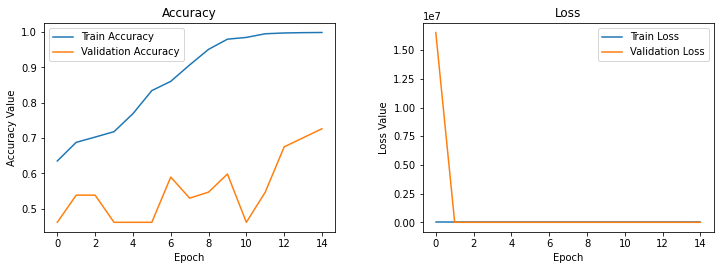

In [55]:
def printHistory(history,):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    f.subplots_adjust(top=0.85, wspace=0.3)

    ax1.plot( history.history['accuracy'], label='Train Accuracy')
    ax1.plot( history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_ylabel('Accuracy Value')
    ax1.set_xlabel('Epoch')
    ax1.set_title('Accuracy')
    l1 = ax1.legend(loc="best")

    ax2.plot( history.history['loss'], label='Train Loss')
    ax2.plot( history.history['val_loss'], label='Validation Loss')
    ax2.set_ylabel('Loss Value')
    ax2.set_xlabel('Epoch')
    ax2.set_title('Loss')
    l2 = ax2.legend(loc="best")
    
printHistory(history)

In [56]:
dir = './DataSet/Images/Autistic/test/'
test_imgs = []
output = []

for images in glob.iglob(f'{dir}/*'):
        output.append(1)
        new_img = Image.open(images)
        test_imgs.append(ImageOps.fit(new_img, (64, 64), Image.ANTIALIAS).convert('RGB'))

In [57]:
dir = './DataSet/Images/Non_Autistic/test/'

for images in glob.iglob(f'{dir}/*'):
        output.append(0)
        new_img = Image.open(images)
        test_imgs.append(ImageOps.fit(new_img, (64, 64), Image.ANTIALIAS).convert('RGB'))

In [59]:
model = load_model('model.h5')

In [60]:
timgs = np.array([np.array(im) for im in test_imgs])
testX = timgs.reshape(timgs.shape[0], 64, 64, 3) / 255

In [61]:
yhat = model.predict(testX)
test_y = lb.inverse_transform(yhat)

In [63]:
from sklearn.metrics import accuracy_score

In [64]:
accuracy_score(output, test_y)

0.5800711743772242